<h1>Salary Predictions Based on Job Descriptions</h1>

# Part 1 - DEFINE

### ---- 1 Define the problem ----

To examine a set of job posting with salaries and use this data to predict the salaries for a new set of job postings.

The job market is complex. HR must have a clear understanding of what an appropriate salary is for a new hire and how various factors can affect the salary offered.


__author__ = 
__email__ =

In [14]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn as sk

## Part 2 - DISCOVER

<h3>2. Load the data</h3>

There are 3 datasets provided for this assignment. Load all three and have a look at the first 5 rows of each.

In [7]:
#load the data into a Pandas dataframe
salary_df = pd.read_csv('data/train_salaries.csv')
salary_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [8]:
train_features_df = pd.read_csv('data/train_features.csv')
train_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [9]:
test_features_df = pd.read_csv('data/test_features.csv')
test_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


<h3>3. Clean the data</h3>

Before using the data, its important to clean the data and look for invalid data (e.g. salaries <= 0), corrupt, or duplicate data and remove it.

The training data comes as two files: one with a jobID and salaries while the features that may affect the offered salary are in another.

In [13]:
# Start with the training files
salary_df.describe()

,salary
count,1000000.000000
mean,116.061818
std,38.717936
min,0.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


The minimum value is 0, which is probably an error.

In [31]:
salary_df.replace(0, "NaN")
salary_df.dropna()
salary_df.describe()

,salary
count,1000000.000000
mean,116.061818
std,38.717936
min,0.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


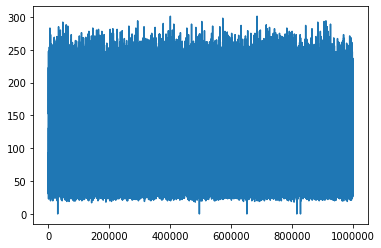

In [32]:
plt.plot(salary_df['salary'])

In [20]:
salary_df.duplicated('jobId').value_counts()

False    1000000
dtype: int64

In [22]:
salary_df.isnull().sum(axis = 0)

jobId     0
salary    0
dtype: int64

In [27]:
missing_data = salary_df.isnull()
missing_data.head()

,jobId,salary
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [28]:
# Loop through each column to find out whether there are missing values
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

salary
False    1000000
Name: salary, dtype: int64



In [12]:
train_features_df.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In the training features data set, 5 of the features are categorical and will likely have duplicates. Check this data for any missing (null) values but not for duplicate values.

In [23]:
train_features_df.isnull().sum(axis=0)

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [17]:
training_df = pd.merge(salary_df, train_features_df, how='inner', on='jobId')
training_df.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [18]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it


AttributeError: 'DataFrame' object has no attribute 'unique'

### ---- 4 Explore the data (EDA) ----

In [3]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

### ---- 5 Establish a baseline ----

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data